In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer 
from lime import submodular_pick

#from pdpbox import pdp, info_plots

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

import warnings
import pickle

sns.set_style(style="ticks")
sns.set_palette(sns.color_palette("Dark2"))

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True 
plt.rcParams["xtick.alignment"] = 'center'
plt.rcParams["ytick.alignment"] = 'center'

from os.path import isfile

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
#print(plt.rcParams.keys())

**Вспомогательные функции и определения.**

In [2]:
colors = {
    0: 'orange',
    1: 'green',
}

labels = {
    0: 'Healthy',
    1: 'Sick'
}

n_class = 2

col_names = [
    'age', 'sex', 'chest_pain_type', 'rst_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 
    'rst_ecg_results', 'max_heart_rate', 'exercise_induced_angina', 'depression_induced_by_exercise', 
    'slope_of_peak_exercise', 'number_of_major_vessels', 'thalassemia', 'healthy', 'health_state'
]

Я решил использовать более-менее полные имена, чтобы "понимать" их значение. Сокращения лично мне понимать крайне сложно.

In [3]:
def get_thershold_predict(predictions: np.array, threshold: float):
    result = []
    
    for val in predictions:
        if val[0] >= threshold:
            result.append(0)
        else:
            result.append(1)
    
    return np.array(result)
    

In [4]:
def plot_roc(predict_proba: np.array, test: np.array, name: str, n_class: int, colors: list, labels: list, fig_size: tuple):
    fp, tp, thr = {}, {}, {}
    
    f, ax = plt.subplots(1, figsize=fig_size)
    plt.title(name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for i in range(n_class):
        fp[i], tp[i], thr[i] = roc_curve(test, predict_proba[:,i], pos_label=i)
        plt.plot(fp[i], tp[i], linestyle='--',color=colors[i], label=labels[i])
    
    plt.show()

**Импорт данных**

In [5]:
exclude_lines = [i for i, line in enumerate(open('./data/src/cleve.mod')) if line.startswith('%')]

src_cleve_df = pd.read_csv(
    filepath_or_buffer='./data/src/cleve.mod',
    delimiter=' ',
    names=col_names,
    skiprows=exclude_lines,
    skipinitialspace=True,
    na_values=['?', -9]
)

In [6]:
src_cleve_df.head()

age   sex chest_pain_type  rst_blood_pressure  serum_cholestoral  \
0  63.0  male          angina               145.0              233.0   
1  67.0  male          asympt               160.0              286.0   
2  67.0  male          asympt               120.0              229.0   
3  37.0  male          notang               130.0              250.0   
4  41.0   fem          abnang               130.0              204.0   

  fasting_blood_sugar rst_ecg_results  max_heart_rate exercise_induced_angina  \
0                true             hyp           150.0                     fal   
1                 fal             hyp           108.0                    true   
2                 fal             hyp           129.0                    true   
3                 fal            norm           187.0                     fal   
4                 fal             hyp           172.0                     fal   

   depression_induced_by_exercise slope_of_peak_exercise  \
0                             2.3                   down   
1                             1.5                   flat   
2                             2.6                   flat   
3                             3.5                   down   
4                             1.4                     up   

   number_of_major_vessels thalassemia healthy health_state  
0                      0.0         fix    buff            H  
1                      3.0        norm    sick           S2  
2                      2.0         rev    sick           S1  
3                      0.0        norm    buff            H  
4                      0.0        norm    buff            H

In [7]:
src_cleve_df.isna().sum()

age                               0
sex                               0
chest_pain_type                   0
rst_blood_pressure                0
serum_cholestoral                 0
fasting_blood_sugar               0
rst_ecg_results                   0
max_heart_rate                    0
exercise_induced_angina           0
depression_induced_by_exercise    0
slope_of_peak_exercise            0
number_of_major_vessels           5
thalassemia                       2
healthy                           0
health_state                      0
dtype: int64

In [8]:
src_cleve_df.shape

(303, 15)

In [9]:
sex = {
    'male': 1,
    'fem':  0
}

# chest pain type
cp = {
    'angina': 1, #typical angina
    'abnang': 2, #atypical angina 
    'notang': 3, #non-anginal pain
    'asympt': 4  #asymptomatic
}

#fasting blood sugar > 120 mg/dl
fbs = {
    'fal':  0,
    'true': 1
}

#resting electrocardiographic results
restecg = {
    'norm': 0, #normal
    'abn':  1, #having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    'hyp':  2  #showing probable or definite left ventricular hypertrophy by Estes' criteria
}

#exercise induced angina (1 = yes; 0 = no)
exang = {
    'fal':  0,
    'true': 1    
}
#the slope of the peak exercise ST segment
slope = {
    'up':   1,
    'flat': 2,
    'down': 3
}


thal = {
    'norm': 3, #normal
    'fix':  6, #fixed defect
    'rev':  7  #reversable defect
}
        
healthy = {
    'buff': 0,
    'sick': 1
}

health_state = {
    'H':  0,
    'S1': 1,
    'S2': 2,
    'S3': 3,
    'S4': 4,
}

In [10]:
X = pd.DataFrame()

X['age'] = src_cleve_df.dropna()['age']
X['sex'] = [sex[x] for x in src_cleve_df.dropna()['sex']]
X['chest_pain_type'] = [cp[x] for x in src_cleve_df.dropna()['chest_pain_type']]
X['rst_blood_pressure'] = src_cleve_df.dropna()['rst_blood_pressure']
X['serum_cholestoral'] = src_cleve_df.dropna()['serum_cholestoral']
X['fasting_blood_sugar'] = [fbs[x] for x in src_cleve_df.dropna()['fasting_blood_sugar']]
X['rst_ecg_results'] = [restecg[x] for x in src_cleve_df.dropna()['rst_ecg_results']]
X['max_heart_rate'] = src_cleve_df.dropna()['max_heart_rate']
X['exercise_induced_angina'] = [exang[x] for x in src_cleve_df.dropna()['exercise_induced_angina']]
X['depression_induced_by_exercise'] = src_cleve_df.dropna()['depression_induced_by_exercise']
X['slope_of_peak_exercise'] = [slope[x] for x in src_cleve_df.dropna()['slope_of_peak_exercise']]
X['number_of_major_vessels'] = src_cleve_df.dropna()['number_of_major_vessels']
X['thalassemia'] = [thal[x] for x in src_cleve_df.dropna()['thalassemia']]

y = np.array(
    [healthy[x] for x in src_cleve_df.dropna()['healthy']]
)

X['healthy'] = y
X['health_state'] = [health_state[x] for x in src_cleve_df.dropna()['health_state']]

In [11]:
X.head()

age  sex  chest_pain_type  rst_blood_pressure  serum_cholestoral  \
0  63.0    1                1               145.0              233.0   
1  67.0    1                4               160.0              286.0   
2  67.0    1                4               120.0              229.0   
3  37.0    1                3               130.0              250.0   
4  41.0    0                2               130.0              204.0   

   fasting_blood_sugar  rst_ecg_results  max_heart_rate  \
0                    1                2           150.0   
1                    0                2           108.0   
2                    0                2           129.0   
3                    0                0           187.0   
4                    0                2           172.0   

   exercise_induced_angina  depression_induced_by_exercise  \
0                        0                             2.3   
1                        1                             1.5   
2                        1                             2.6   
3                        0                             3.5   
4                        0                             1.4   

   slope_of_peak_exercise  number_of_major_vessels  thalassemia  healthy  \
0                       3                      0.0            6        0   
1                       2                      3.0            3        1   
2                       2                      2.0            7        1   
3                       3                      0.0            3        0   
4                       1                      0.0            3        0   

   health_state  
0             0  
1             2  
2             1  
3             0  
4             0

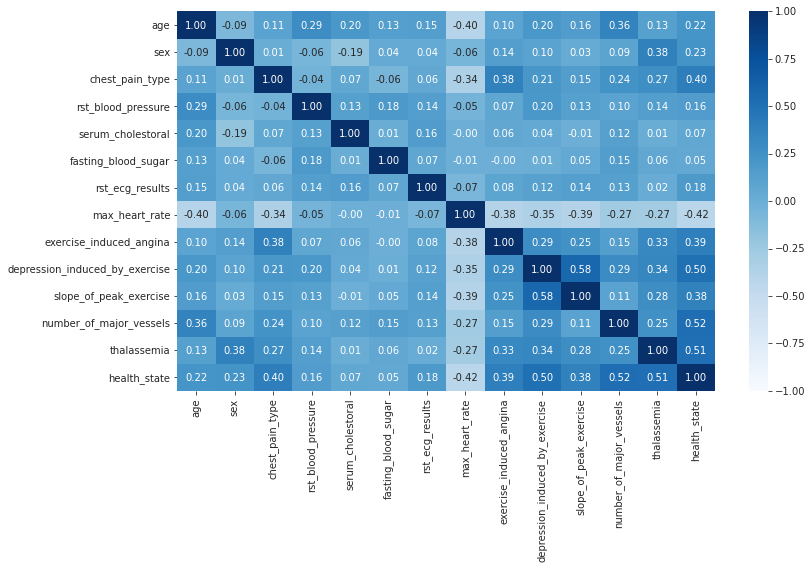

In [12]:
a = sns.heatmap(data=X.loc[:, X.columns != 'healthy'].corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

Интересно, что максимальный пульс неплохо связан почти со всеми остальными параметрами.

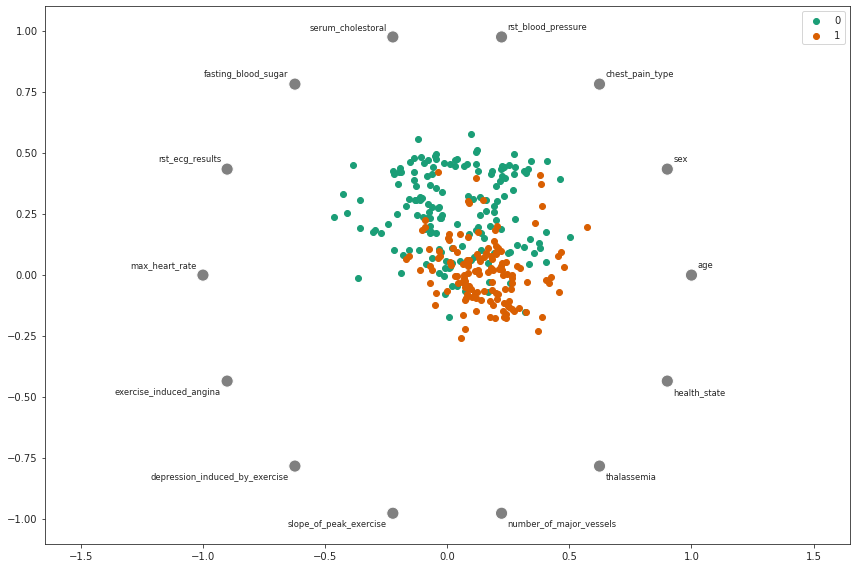

In [13]:
f, ax = plt.subplots(figsize=(12, 8))
a = pd.plotting.radviz(frame=X, class_column='healthy', color=sns.color_palette())

Ничего особенного в данных нет. 

**Бинарная модель**

Замысел следующий. Я хочу оценить разницу в определении здоровых и больных пациентов разными типами классификации. Оценить значимость параметров для разных типов и сравнить их. 

Попробую наивный Байес и логистическую регрессию. Как самые простые бинарные классификаторы. В качестве базовых моделей.

In [14]:
X_ = X.drop(['healthy', 'health_state'], axis=1)
y_ = y

X_ = pd.DataFrame(StandardScaler().fit_transform(X_), columns=X_.columns)

Подбирать гиперпараметры буду без изысков, полным перебором вариантов.

In [15]:
model_nb = GaussianNB()

if isfile("./data/models/model_nb.pkl"):
    with open("./data/models/model_nb.pkl", "rb") as m_file:
        model_nb = pickle.load(m_file)
else:
    model_nb_best = GaussianNB()
    
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    best_score = 0
    for train_index, test_index in cross_val.split(X_, y_):
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_[train_index], y_[test_index]
        
        model_nb.fit(X_train, y_train)
        model_nb_pred = model_nb.predict(X_test)
        
        score = roc_auc_score(y_test, model_nb_pred)
        
        if score > best_score:
            best_score = score
            model_nb_best = model_nb
    
    model_nb = model_nb_best
    with open("./data/models/model_nb.pkl", "wb") as m_file:
        pickle.dump(model_nb_best, m_file)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [17]:
lr_result = None

if isfile("./data/models/model_lr.pkl"):
    with open("./data/models/model_lr.pkl", "rb") as m_file:
        lr_result = pickle.load(m_file)
else:
    model_lr = LogisticRegression()
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy', error_score=0)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result = grid_search.fit(X_train, y_train)
    
    with open("./data/models/model_lr.pkl", "wb") as m_file:
        pickle.dump(lr_result, m_file)

In [18]:
model_nb_pred = model_nb.predict(X_test)
model_lr_pred = lr_result.best_estimator_.predict(X_test)
print('AUC for Naive Bayes :\t{:.8f}'.format(roc_auc_score(y_test, model_nb_pred)))
print('AUC for Logistic Regression :\t{:.8f}'.format(roc_auc_score(y_test, model_lr_pred)))

AUC for Naive Bayes :	0.79687500
AUC for Logistic Regression :	0.79687500


Хм, абсолютно одинаковые AUC... 

In [19]:
model_nb_proba = model_nb.predict_proba(X_test)
model_lr_proba = lr_result.best_estimator_.predict_proba(X_test)

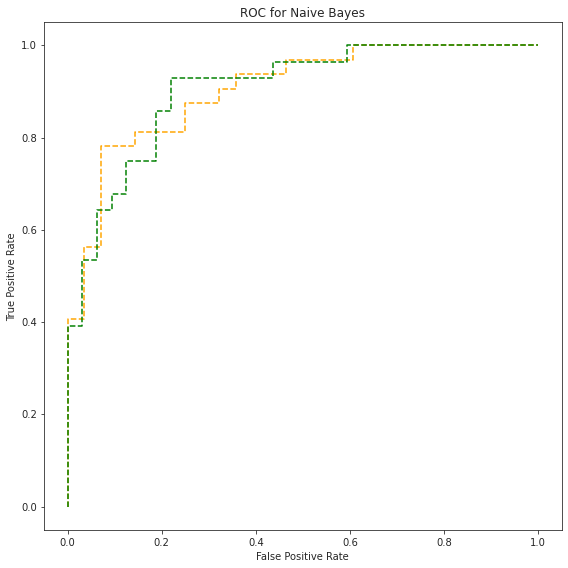

In [20]:
plot_roc(model_nb_proba, y_test, 'ROC for Naive Bayes', 2, colors, labels, (8, 8))

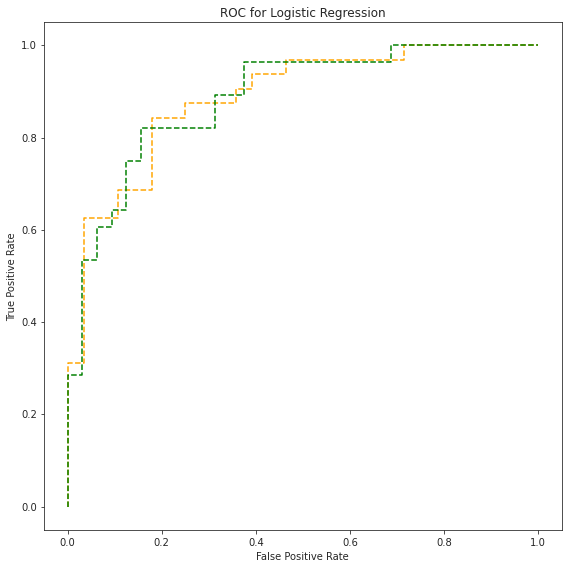

In [21]:

plot_roc(model_lr_proba, y_test, 'ROC for Logistic Regression', 2, colors, labels, (8, 8))

А вот ROC разные. Так и не понял, как такое получается.

In [22]:
print(confusion_matrix(y_test, model_nb_pred))

[[27  5]
 [ 7 21]]


In [23]:
print(confusion_matrix(y_test, model_lr_pred))

[[27  5]
 [ 7 21]]


Интересно, а ошибаются модели в одних и тех-же местах?

In [24]:
nb_lr_compare = []

for idx, val in enumerate(y_test):
    if val != model_lr_pred[idx] or val != model_nb_pred[idx]:
        row = [idx, y_test[idx], model_lr_pred[idx], model_nb_pred[idx]]
        nb_lr_compare.append(row)
        
nb_lr_compare_df = pd.DataFrame(data=nb_lr_compare, columns=['index', 'ground_thrue', 'log_reg_mismatch', 'naive_bayes_mismatch'])
nb_lr_compare_df

index  ground_thrue  log_reg_mismatch  naive_bayes_mismatch
0      13             1                 1                     0
1      20             0                 1                     0
2      23             0                 1                     1
3      27             1                 0                     0
4      28             0                 0                     1
5      31             1                 0                     0
6      32             1                 0                     0
7      39             1                 0                     0
8      44             0                 1                     1
9      49             0                 1                     1
10     54             1                 0                     1
11     55             1                 0                     0
12     58             0                 1                     1
13     59             1                 0                     0

Нет, значит все-таки совпадение AUC это не глюк, а таки совпадение.

Попробую оценить наиболее значимые параметры для каждой из моделей.

**Оченка значимости предикторов на основании пермутации данных**

In [25]:
lr_perm = PermutationImportance(lr_result.best_estimator_, random_state=42, scoring='r2', n_iter=100).fit(X_, y_)
eli5.explain_weights(lr_perm, feature_names=X_.columns.values)

Explanation(estimator="PermutationImportance(estimator=LogisticRegression(C=1, solver='sag'),\n                      n_iter=100, random_state=42, scoring='r2')", description="\nFeature importances, computed as a decrease in score when feature\nvalues are permuted (i.e. become noise). This is also known as \npermutation importance.\n\nIf feature importances are computed on the same data as used for training, \nthey don't reflect importance of features for generalization. Use a held-out\ndataset if you want generalization feature importances.\n", error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='number_of_major_vessels', weight=0.25818382352941177, std=0.06809573114945272, value=None), FeatureWeight(feature='sex', weight=0.1602426470588237, std=0.040744385399819144, value=None), FeatureWeight(feature='thalassemia', weight=0.14378308823529426, std=0.04987866698606822, value=None), FeatureWeight(feature='max_heart_rate', weight=0.05277941176470596, std=0.040043510072943614, value=None), FeatureWeight(feature='chest_pain_type', weight=0.046930147058823604, std=0.053429436956193774, value=None), FeatureWeight(feature='fasting_blood_sugar', weight=0.019996323529411816, std=0.02540911439193673, value=None), FeatureWeight(feature='exercise_induced_angina', weight=0.014011029411764749, std=0.02682608986868444, value=None), FeatureWeight(feature='slope_of_peak_exercise', weight=0.013194852941176515, std=0.02421590988202506, value=None), FeatureWeight(feature='rst_blood_pressure', weight=0.0008161764705882801, std=0.02806428856785914, value=None), FeatureWeight(feature='depression_induced_by_exercise', weight=0.00027205882352944965, std=0.028271873326095362, value=None), FeatureWeight(feature='age', weight=-0.005033088235294074, std=0.019585873530006015, value=None), FeatureWeight(feature='rst_ecg_results', weight=-0.017955882352941134, std=0.020619115496922556, value=None), FeatureWeight(feature='serum_cholestoral', weight=-0.020132352941176424, std=0.03958806458096222, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [26]:
nb_perm = PermutationImportance(model_nb, random_state=42, scoring='r2', n_iter=100).fit(X_, y_)
eli5.explain_weights(nb_perm, feature_names=X_.columns.values)

Explanation(estimator="PermutationImportance(estimator=GaussianNB(), n_iter=100, random_state=42,\n                      scoring='r2')", description="\nFeature importances, computed as a decrease in score when feature\nvalues are permuted (i.e. become noise). This is also known as \npermutation importance.\n\nIf feature importances are computed on the same data as used for training, \nthey don't reflect importance of features for generalization. Use a held-out\ndataset if you want generalization feature importances.\n", error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='thalassemia', weight=0.2003713235294117, std=0.048433156965693384, value=None), FeatureWeight(feature='number_of_major_vessels', weight=0.1862242647058825, std=0.04368620085588339, value=None), FeatureWeight(feature='depression_induced_by_exercise', weight=0.13915808823529438, std=0.04551825436965621, value=None), FeatureWeight(feature='exercise_induced_angina', weight=0.125419117647059, std=0.044645010439912904, value=None), FeatureWeight(feature='chest_pain_type', weight=0.11956985294117663, std=0.035953734109709146, value=None), FeatureWeight(feature='max_heart_rate', weight=0.09032352941176482, std=0.03518510585283827, value=None), FeatureWeight(feature='sex', weight=0.07345588235294132, std=0.027944030427001585, value=None), FeatureWeight(feature='rst_blood_pressure', weight=0.057404411764705954, std=0.021036674753595937, value=None), FeatureWeight(feature='slope_of_peak_exercise', weight=0.040672794117647085, std=0.029646610887065997, value=None), FeatureWeight(feature='rst_ecg_results', weight=0.021628676470588273, std=0.01962739906379638, value=None), FeatureWeight(feature='serum_cholestoral', weight=0.016867647058823546, std=0.019817389191310274, value=None), FeatureWeight(feature='age', weight=0.011426470588235316, std=0.022245696193532533, value=None), FeatureWeight(feature='fasting_blood_sugar', weight=0.0023125000000000185, std=0.008615076753559617, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

А вот это очень интересно. Пермутация по разному влияет на модели. Что, вероятно, связанно с разными алгоритмами "под капотом".

Я выбрал R2 оценку, как более наглядную.

**LIME**

Далее я хочу посмотреть как предикторы влияют на конкретные предсказания. Интересно сравнить достоверные и ошибочные предсказания для обеих моделей.

In [33]:
explainer_lr = LimeTabularExplainer(
    X_test,
    feature_names=X_test.columns, 
    class_names=['healthy', 'sick'], 
    discretize_continuous=False, 
    verbose=True
)

warnings.simplefilter("ignore", UserWarning)

for i in range(5):
    lime_2 = explainer_lr.explain_instance(X_test.iloc[i], lr_result.best_estimator_.predict_proba, num_features=13)
    lime_2.show_in_notebook(show_table=True)

Intercept 0.4809504169751918
Prediction_local [0.08738138]
Right: 0.06448004842946078


Intercept 0.47899078214477087
Prediction_local [-0.18525164]
Right: 0.010213113022242329


Intercept 0.4787765464878375
Prediction_local [0.17660924]
Right: 0.11367738544156478


Intercept 0.48100054264984654
Prediction_local [-0.07754606]
Right: 0.02180565464580518


Intercept 0.4813152811243954
Prediction_local [0.1012047]
Right: 0.06806497476455323


In [28]:
sp_obj = submodular_pick.SubmodularPick(explainer_lr, X_test, lr_result.best_estimator_.predict_proba, sample_size=5, num_features=13, num_exps_desired=5)

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

KeyError: 18